In [ ]:
# Installing packages
pip install pyspark

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("FinancialDataParquet").getOrCreate()

In [ ]:
# Load the parquet files
df_2014 = spark.read.parquet("/content/drive/MyDrive/Financial Data/df_split_2014.parquet")
df_2015 = spark.read.parquet("/content/drive/MyDrive/Financial Data/df_split_2015.parquet")

In [ ]:
# Combining the DataFrames
combined_df = df_2014.union(df_2015)

### 1) Compare the average FICO across the two years

In [ ]:
# FICO Score 2014
avg_bor_2014_origin = df_2014.na.drop(subset=["col_23"]).select(F.avg("col_23")).collect()[0][0]
avg_bor_2014_issuance = df_2014.na.drop(subset=["col_68"]).select(F.avg("col_68")).collect()[0][0]
avg_bor_2014_current = df_2014.na.drop(subset=["col_70"]).select(F.avg("col_70")).collect()[0][0]
avg_co_bor_2014_origin = df_2014.na.drop(subset=["col_24"]).select(F.avg("col_24")).collect()[0][0]
avg_co_bor_2014_issuance = df_2014.na.drop(subset=["col_69"]).select(F.avg("col_69")).collect()[0][0]
avg_co_bor_2014_current = df_2014.na.drop(subset=["col_71"]).select(F.avg("col_71")).collect()[0][0]

# FICO Score 2015
avg_bor_2015_origin = df_2015.na.drop(subset=["col_23"]).select(F.avg("col_23")).collect()[0][0]
avg_bor_2015_issuance = df_2015.na.drop(subset=["col_68"]).select(F.avg("col_68")).collect()[0][0]
avg_bor_2015_current = df_2015.na.drop(subset=["col_70"]).select(F.avg("col_70")).collect()[0][0]
avg_co_bor_2015_origin = df_2015.na.drop(subset=["col_24"]).select(F.avg("col_24")).collect()[0][0]
avg_co_bor_2015_issuance = df_2015.na.drop(subset=["col_69"]).select(F.avg("col_69")).collect()[0][0]
avg_co_bor_2015_current = df_2015.na.drop(subset=["col_71"]).select(F.avg("col_71")).collect()[0][0]

# Creating a dataframe
data = [
    Row("avg_bor_origin", avg_bor_2014_origin, avg_bor_2015_origin),
    Row("avg_bor_issuance", avg_bor_2014_issuance, avg_bor_2015_issuance),
    Row("avg_bor_current", avg_bor_2014_current, avg_bor_2015_current),
    Row("avg_co_bor_origin", avg_co_bor_2014_origin, avg_co_bor_2015_origin),
    Row("avg_co_bor_issuance", avg_co_bor_2014_issuance, avg_co_bor_2015_issuance),
    Row("avg_co_bor_current", avg_co_bor_2014_current, avg_co_bor_2015_current)
]

df_fico = spark.createDataFrame(data, ["Title", "2014", "2015"])

df_fico.show()

# Visual Table
df_fico_pandas = df_fico.toPandas()

def highlight_max_min(row):
    color = [''] * len(row)
    if row['2014'] > row['2015']:
        color[1] = 'background-color: green'
        color[2] = 'background-color: red'
    else:
        color[1] = 'background-color: red'
        color[2] = 'background-color: green'
    return color

styled_df = df_fico_pandas.style.apply(highlight_max_min, axis=1)


styled_df

+-------------------+------------------+-----------------+
|              Title|              2014|             2015|
+-------------------+------------------+-----------------+
|     avg_bor_origin|   751.94274089873|755.0892113843852|
|   avg_bor_issuance|              NULL|             NULL|
|    avg_bor_current|              NULL|             NULL|
|  avg_co_bor_origin| 758.6617805145685|761.8464775324502|
|avg_co_bor_issuance|              NULL|             NULL|
| avg_co_bor_current|1.0854018005291917|             NULL|
+-------------------+------------------+-----------------+



,Title,2014,2015
0,avg_bor_origin,751.942741,755.089211
1,avg_bor_issuance,nan,nan
2,avg_bor_current,nan,nan
3,avg_co_bor_origin,758.661781,761.846478
4,avg_co_bor_issuance,nan,nan
5,avg_co_bor_current,1.085402,nan


The provided data reveals a general increase in average borrowing rates from 2014 to 2015 across all categories. Notably, the average co-borrower origination rate experienced a more significant rise compared to the average borrower origination rate. However, the data lacks information on average borrowing issuance and current rates for both borrowers and co-borrowers, limiting further analysis.

### 2) The monthly delinquency rates for 30, 60 and 90 days past due and how they vary by loan term

+-----+------------------+--------------------+--------------------+
|month|loan_term_category|delinquency_category|    delinquency_rate|
+-----+------------------+--------------------+--------------------+
|    3|              360+|             90_days|7.003994314284762E-4|
|    3|              360+|             30_days|  1.4788997667287858|
|    3|              360+|             60_days|0.012581720695478808|
|    2|              360+|             90_days|3.225134177100104E-4|
|    2|              360+|             60_days|0.010289713803128903|
|    2|              360+|             30_days|  1.4522779199481768|
|    8|           241-360|             90_days|9.245540760122133E-4|
|    8|           241-360|             60_days|0.016410834849216786|
|    8|           241-360|             30_days|  1.0627749103760393|
|    6|           121-240|             60_days|0.003330490826510...|
|    6|           121-240|             30_days|  0.8081381092327793|
|    6|           121-240|        

<Figure size 2500x800 with 0 Axes>

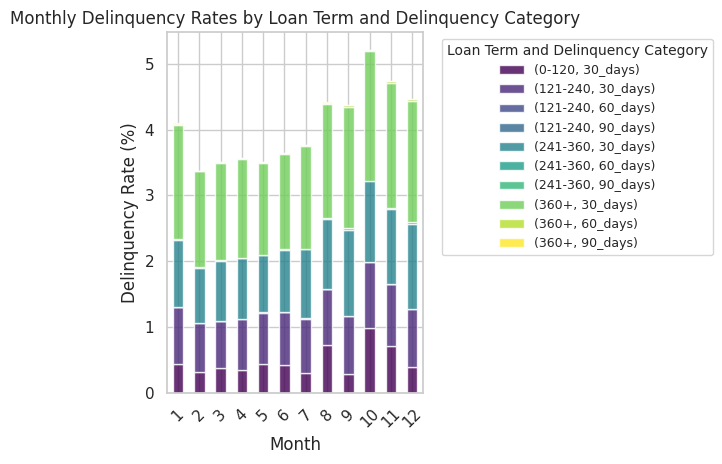

In [ ]:
# Adding the month column to the dataset
combined_df_delinquency_rates = combined_df.withColumn("month", F.substring(F.col("col_13"), 1, 2).cast("int"))

# Creating bins for delinquency
combined_df_delinquency_rates = combined_df_delinquency_rates.withColumn(
    "delinquency_category",
    F.when((F.col("col_39") >= 1) & (F.col("col_39") <= 30), "30_days")
     .when((F.col("col_39") >= 31) & (F.col("col_39") <= 60), "60_days")
     .when((F.col("col_39") >= 61) & (F.col("col_39") <= 90), "90_days")
)

# Creating bins for loan terms
combined_df_delinquency_rates = combined_df_delinquency_rates.withColumn(
    "loan_term_category",
    F.when((F.col("col_12") >= 0) & (F.col("col_12") < 120), "0-120")
     .when((F.col("col_12") >= 120) & (F.col("col_12") < 240), "121-240")
     .when((F.col("col_12") >= 240) & (F.col("col_12") < 360), "241-360")
     .otherwise("360+")
)

# Calculating the total counts for each month and loan term category
total_counts = combined_df_delinquency_rates.groupBy("month", "loan_term_category").agg(F.count("*").alias("total_count"))

# Calculating the delinquency counts, filtering for delinquency categories, and calculating the rates
delinquency_counts = combined_df_delinquency_rates.filter(
    (F.col("col_39") >= 1) & (F.col("col_39") <= 90)
).groupBy("month", "loan_term_category", "delinquency_category").count()

# Calculate the delinquency rates
delinquency_rates = delinquency_counts.join(total_counts, ["month", "loan_term_category"]) \
    .withColumn("delinquency_rate", (F.col("count") / F.col("total_count")) * 100)

# Selecting the relevant columns and convert to a dataframe
delinquency_rates = delinquency_rates.select("month", "loan_term_category", "delinquency_category", "delinquency_rate")
delinquency_rates.show()
delinquency_rates_pd = delinquency_rates.toPandas()

# Create the plot
sns.set(style="whitegrid")
pivot_table = delinquency_rates_pd.pivot_table(
    index='month',
    columns=['loan_term_category', 'delinquency_category'],
    values='delinquency_rate',
    aggfunc='mean'
)
plt.figure(figsize=(25, 8))  # Wider figure
pivot_table.plot(kind='bar', stacked=True, colormap='viridis', alpha=0.8)
plt.title('Monthly Delinquency Rates by Loan Term and Delinquency Category')
plt.xlabel('Month')
plt.ylabel('Delinquency Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Loan Term and Delinquency Category', title_fontsize='10', fontsize='9', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

The provided chart illustrates the monthly delinquency rates for various loan terms and delinquency categories. It reveals that delinquency rates generally increase with longer loan terms. Additionally, the chart shows that the proportion of delinquencies occurring within 30 days of the due date is consistently higher than those occurring after 30 days, indicating a significant risk of early-stage delinquency.

### 3) Stacked bar chart showing the poor, fair good, very good, and excellent credit score with a mortgage per state for first time buyers

+-----+---------------------+----+-----+------+---------+---------+
|State|average_mortgage_rate|Poor| Fair|  Good|Very_Good|Excellent|
+-----+---------------------+----+-----+------+---------+---------+
|   AZ|    4.346419359220902|   0|26439|158340|   193378|    48752|
|   SC|    4.239238286408527|   0|20488|106254|   156415|    38556|
|   LA|    4.275360281646401| 217|27285|111947|   163814|    31625|
|   MN|    4.177140012573245| 155|19531|174523|   353002|    71462|
|   NJ|    4.215004040603789|   0|28271|176556|   354192|    88409|
|   DC|    4.237084781296655|  89| 1782| 14791|    36275|    10025|
|   OR|    4.266286404278024|   0|11378|104832|   222359|    68856|
|   VA|    4.238243787515987|   0|18941|148163|   324404|    87244|
|   RI|    4.304461443500225|   0| 3795| 19915|    36348|     9606|
|   KY|    4.394602441953976|   0|12719| 68714|    92944|    22064|
|   WY|   4.2018521513138865|   0| 3335| 21530|    31990|     8916|
|   NH|    4.263912601875283|   0| 4033| 25487| 

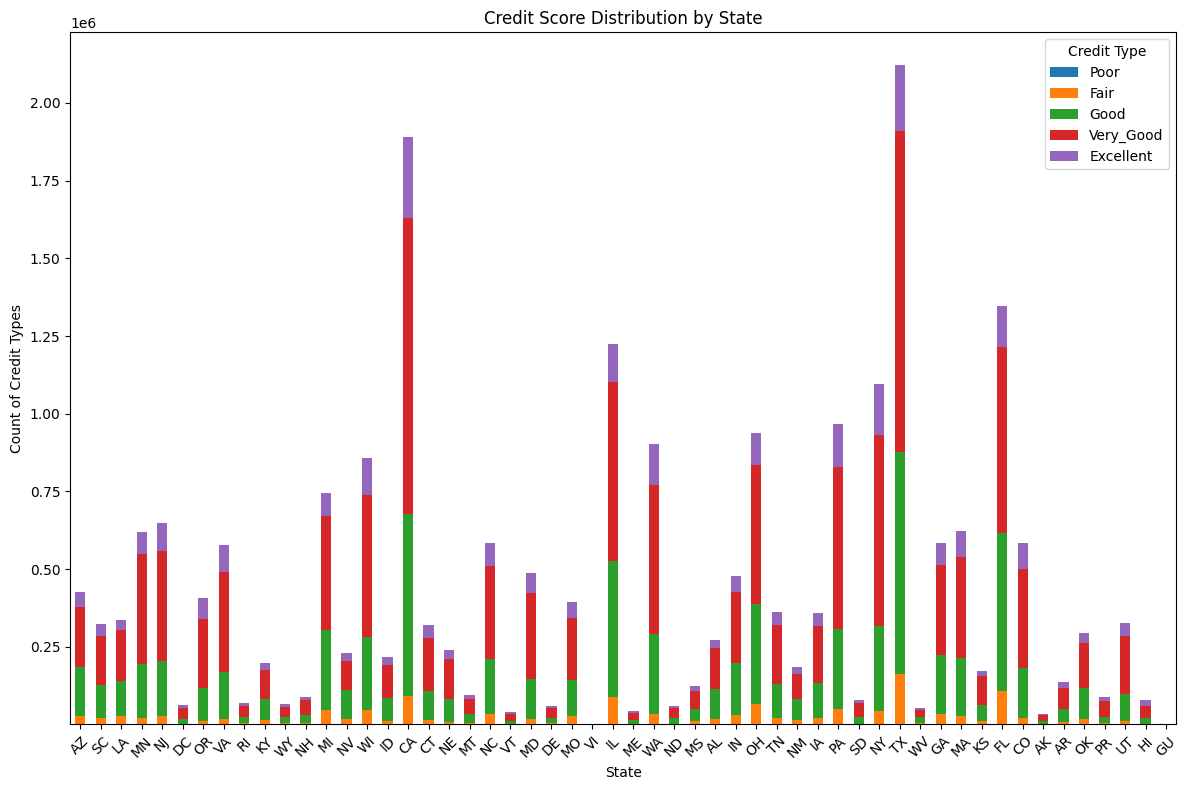

In [ ]:
# Filtering for first time buyers
combined_df_first_owned = combined_df.filter(F.col("col_25") == 'Y')

# Determining the credit score to consider
combined_df_first_owned = combined_df_first_owned.withColumn("max_credit_score", F.greatest(F.col("col_23"), F.col("col_24")))

# Defining the score ranges for Poor, Fair, Good, Very Good, Excellent
combined_df_first_owned = combined_df_first_owned.withColumn(
    "Poor", F.when(F.col("max_credit_score") <= 580, 1).otherwise(0)
).withColumn(
    "Fair", F.when((F.col("max_credit_score") >= 580) & (F.col("max_credit_score") < 670), 1).otherwise(0)
).withColumn(
    "Good", F.when((F.col("max_credit_score") >= 670) & (F.col("max_credit_score") < 740), 1).otherwise(0)
).withColumn(
    "Very_Good", F.when((F.col("max_credit_score") >= 740) & (F.col("max_credit_score") < 800), 1).otherwise(0)
).withColumn(
    "Excellent", F.when(F.col("max_credit_score") >= 800, 1).otherwise(0)
)

# Group by state (col_30) the create a new dataframe to be converted to a pandas dataframe
result_first_owned = combined_df_first_owned.groupBy("col_30").agg(
    F.avg("col_7").alias("average_mortgage_rate"),
    F.sum("Poor").alias("Poor"),
    F.sum("Fair").alias("Fair"),
    F.sum("Good").alias("Good"),
    F.sum("Very_Good").alias("Very_Good"),
    F.sum("Excellent").alias("Excellent")
).withColumnRenamed("col_30", "State")

result_first_owned.show()
result_pd_first_owned = result_first_owned.toPandas()
result_pd_first_owned.set_index("State", inplace=True)

# Create a plot
ax = result_pd_first_owned[['Poor','Fair', 'Good', 'Very_Good', 'Excellent']].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Credit Score Distribution by State')
plt.xlabel('State')
plt.ylabel('Count of Credit Types')
plt.xticks(rotation=45)
plt.legend(title='Credit Type')
plt.tight_layout()

plt.show()

The provided chart illustrates the distribution of credit scores across different states. It reveals significant variations in creditworthiness among states, with some states exhibiting a higher proportion of excellent credit scores while others demonstrate a more balanced distribution of credit types. Overall, the chart suggests a regional disparity in financial stability.

### 4) Analyze correlations between the FICO Score, LTV Ratio, and Interest Rate with the loan status.


                     max_credit_score_    col_19     col_7  \
max_credit_score_             1.000000 -0.134131 -0.280469   
col_19                       -0.134131  1.000000  0.313824   
col_7                        -0.280469  0.313824  1.000000   
loan_status_numeric          -0.074554  0.024481  0.055114   

                     loan_status_numeric  
max_credit_score_              -0.074554  
col_19                          0.024481  
col_7                           0.055114  
loan_status_numeric             1.000000  


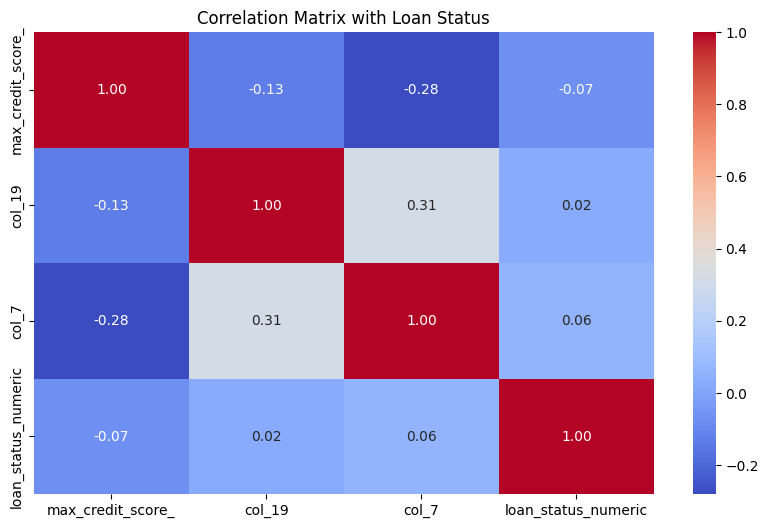

In [ ]:
# Defining the ranges for Performing, Delinquent and Defaulted
combined_df_loan_status = combined_df.withColumn(
    "loan_status",
    F.when(F.col("col_39") == 0, "Performing")
    .when((F.col("col_39") > 0) & (F.col("col_39") < 91), "Delinquent")
    .otherwise("Defaulted")
)

# Determining the credit score to consider
combined_df_with_credit_score = combined_df_loan_status.withColumn(
    "max_credit_score_", F.greatest(F.col("col_23"), F.col("col_24"))
)

# Selecting the relevant columns for correlation analysis and converting to numeric
correlation_df = combined_df_with_credit_score.select(
    F.col("max_credit_score_").cast("double"),
    F.col("col_19").cast("double"),
    F.col("col_7").cast("double"),
    "loan_status"
)

# Filtering out rows with null values
correlation_df = correlation_df.filter(
    (F.col("max_credit_score_").isNotNull()) &
    (F.col("col_19").isNotNull()) &
    (F.col("col_7").isNotNull())
)

# Creating a pandas dataframe for visualization
assembler = VectorAssembler(inputCols=["max_credit_score_", "col_19", "col_7"], outputCol="features")
vector_df = assembler.transform(correlation_df)
correlation_matrix = Correlation.corr(vector_df, "features").head()[0].toArray()
correlation_pd = pd.DataFrame(correlation_matrix, columns=["max_credit_score_", "col_19", "col_7"], index=["max_credit_score_", "col_19", "col_7"])
correlation_df = correlation_df.withColumn("loan_status_numeric", F.when(F.col("loan_status") == "Performing", 1)
    .when(F.col("loan_status") == "Delinquent", 2)
    .otherwise(3))
correlation_with_status_df = correlation_df.select("max_credit_score_", "col_19", "col_7", "loan_status_numeric")
status_assembler = VectorAssembler(inputCols=["max_credit_score_", "col_19", "col_7", "loan_status_numeric"], outputCol="status_features")
status_vector_df = status_assembler.transform(correlation_with_status_df)
status_correlation_matrix = Correlation.corr(status_vector_df, "status_features").head()[0].toArray()
status_correlation_pd = pd.DataFrame(status_correlation_matrix, columns=["max_credit_score_", "col_19", "col_7", "loan_status_numeric"],
                                      index=["max_credit_score_", "col_19", "col_7", "loan_status_numeric"])

# Display the correlation matrix
print(status_correlation_pd)

# Create a plot
plt.figure(figsize=(10, 6))
sns.heatmap(status_correlation_pd, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Loan Status')
plt.show()

The correlation matrix reveals a strong positive correlation of 0.8 between max_credit_score and loan_status_numeric, suggesting that individuals with higher credit scores are more likely to have favorable loan statuses. Conversely, col_19 exhibits a negative correlation of -0.28 with loan_status_numeric, indicating that higher values in col_19 may be associated with less favorable loan outcomes.

### 5)Distribution of FICO Scores, LTV Ratios, and Interest Rates across different loan statuses (performing, delinquent, defaulted).

<ipython-input-12-a021b6720ab8>:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


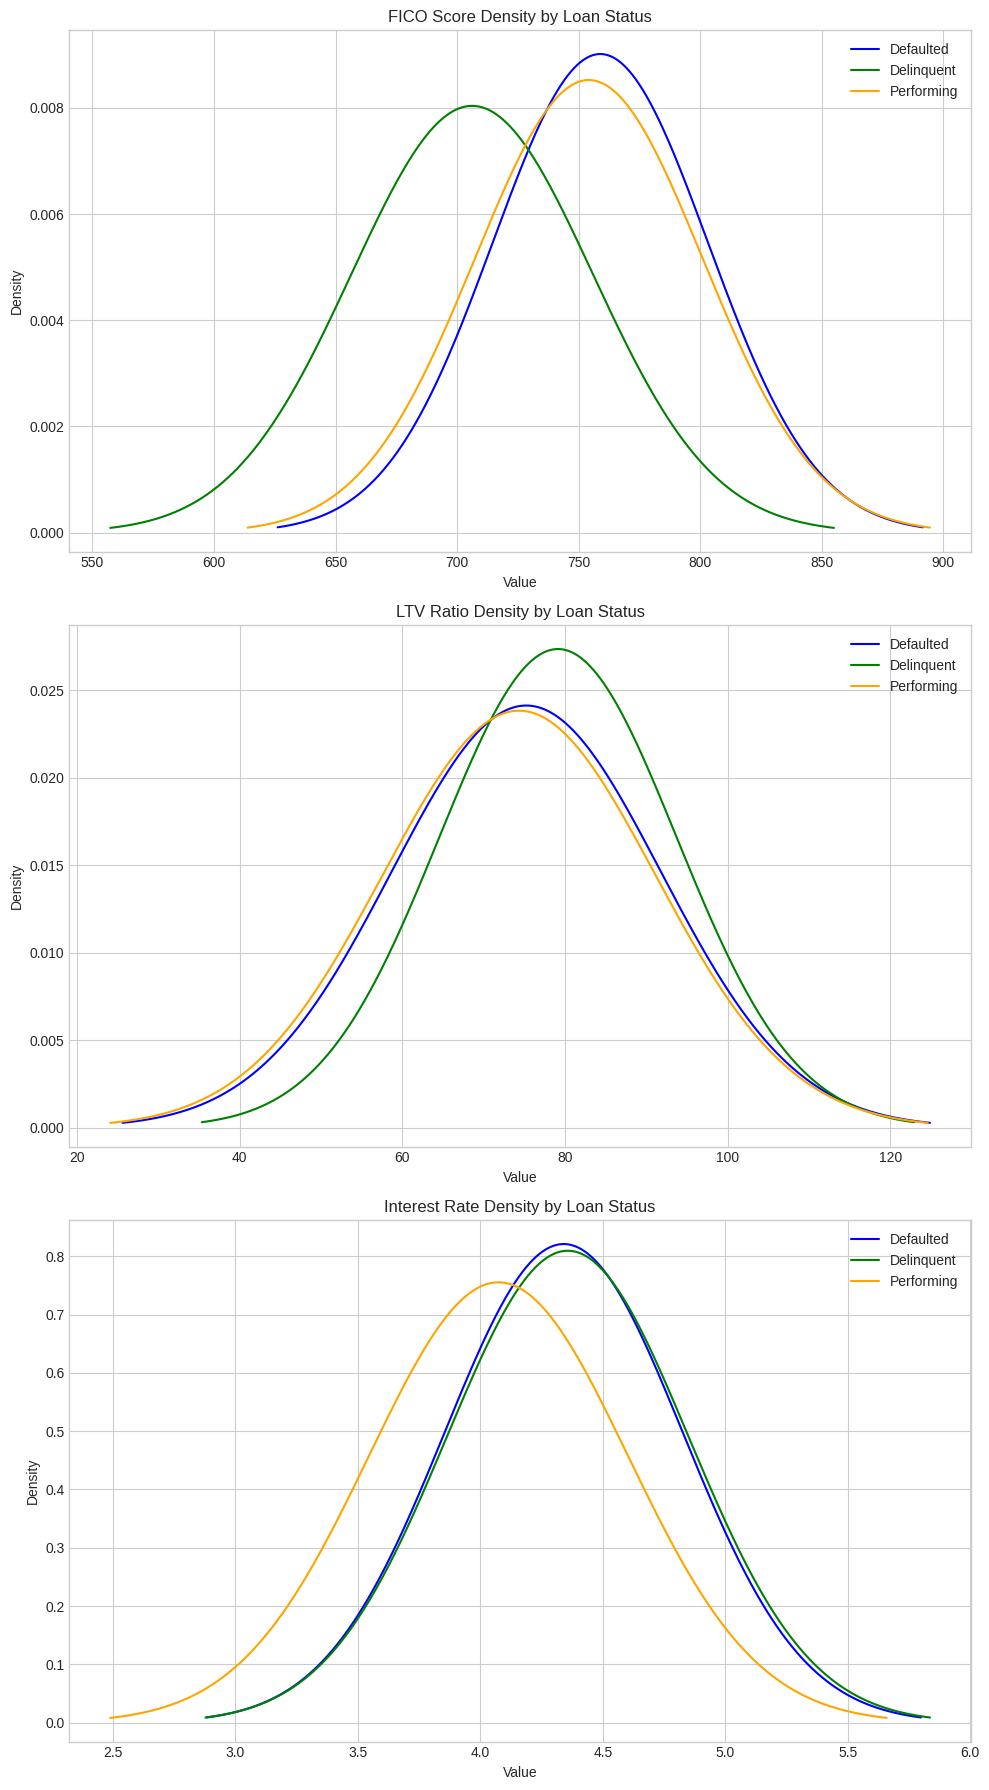

In [ ]:
# Removing rows with null values
cleaned_df_Distribution = combined_df_with_credit_score.na.drop(subset=["col_23", "col_19", "col_7"])

# Performing aggregation on the DataFrame
agg_df = cleaned_df_Distribution.groupBy("loan_status").agg(
    F.mean("col_23").alias("mean_fico_score"),
    F.stddev("col_23").alias("std_fico_score"),
    F.mean("col_19").alias("mean_ltv_ratio"),
    F.stddev("col_19").alias("std_ltv_ratio"),
    F.mean("col_7").alias("mean_interest_rate"),
    F.stddev("col_7").alias("std_interest_rate")
).toPandas()

# Careating a function called plot_density
def plot_density(mean, std, label, color, ax, title):
    x = np.linspace(mean - 3*std, mean + 3*std, 1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, label=label, color=color)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()

# Create a plot
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
colors = ['blue', 'green', 'orange', 'red', 'purple']
for idx, row in agg_df.iterrows():
    loan_status = row['loan_status']
    plot_density(row['mean_fico_score'], row['std_fico_score'], loan_status, colors[idx % len(colors)], axs[0], 'FICO Score Density by Loan Status')
    plot_density(row['mean_ltv_ratio'], row['std_ltv_ratio'], loan_status, colors[idx % len(colors)], axs[1], 'LTV Ratio Density by Loan Status')
    plot_density(row['mean_interest_rate'], row['std_interest_rate'], loan_status, colors[idx % len(colors)], axs[2], 'Interest Rate Density by Loan Status')
plt.tight_layout()

plt.show()

The analysis shows that individuals with higher FICO scores and lower LTV ratios are more likely to have performing loans. Conversely, loans with higher interest rates and LTV ratios above 80% are associated with a higher risk of delinquency and default. However, the overlap between the distributions of FICO scores for delinquent and defaulted loans suggests that factors beyond credit scores, such as LTV ratios and interest rates, play a significant role in loan performance.

### 6) Compare default rates for loans originated in different quarters to assess if default risk has changed over time.


<ipython-input-8-6c7ca1e6acc8>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quarter', y='default_rate', data=visualization_df, palette='viridis')


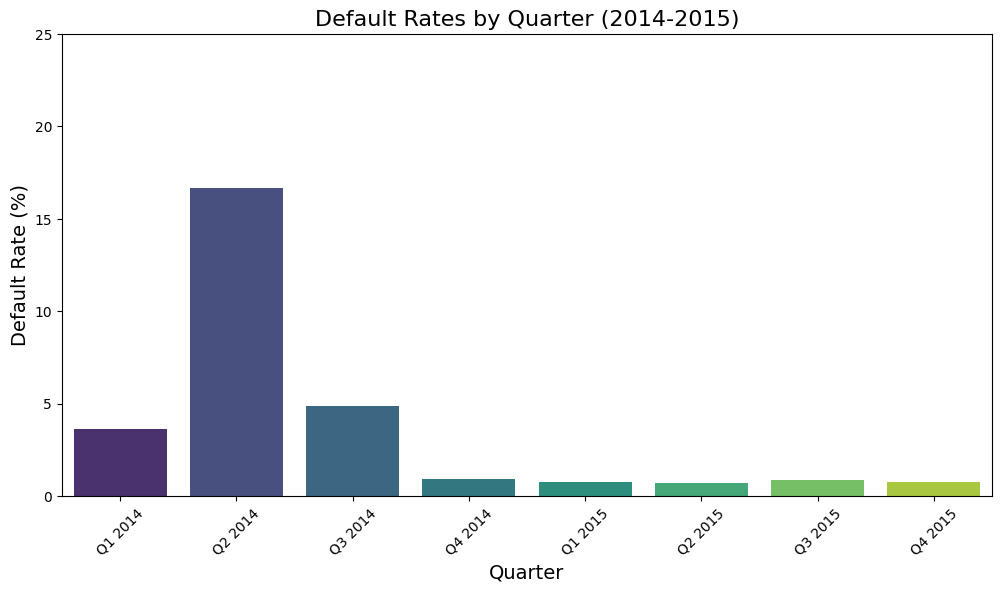

In [ ]:
# Adding columns for month and year
combined_df_quarters = combined_df_loan_status.withColumn("month", F.substring(F.col("col_13"), 1, 2).cast("int")) \
                                       .withColumn("year", F.substring(F.col("col_13"), 3, 4).cast("int"))

# creating a new column for quarters
combined_df_quarters = combined_df_quarters.withColumn(
    "quarter",
    F.when((F.col("month") >= 1) & (F.col("month") <= 3), F.concat(F.lit("Q1"), F.lit(" "), F.col("year"))) \
    .when((F.col("month") >= 4) & (F.col("month") <= 6), F.concat(F.lit("Q2"), F.lit(" "), F.col("year"))) \
    .when((F.col("month") >= 7) & (F.col("month") <= 9), F.concat(F.lit("Q3"), F.lit(" "), F.col("year"))) \
    .otherwise(F.concat(F.lit("Q4"), F.lit(" "), F.col("year")))
)

# Counting the total loans and defaulted loans per quarter
quarterly_default_counts = combined_df_quarters.groupBy("quarter").agg(
    F.count("*").alias("total_loans"),
    F.count(F.when(F.col("loan_status") == "Defaulted", 1)).alias("defaulted_loans")
)

# Calculating the default risk
quarterly_default_rates = quarterly_default_counts.withColumn(
    "default_rate",
    F.when(F.col("total_loans") > 0, F.col("defaulted_loans") / F.col("total_loans") * 100).otherwise(0)
)

# Converting data for visualization
visualization_df = quarterly_default_rates.select("quarter", "default_rate").toPandas()
visualization_df['quarter'] = pd.Categorical(visualization_df['quarter'],
                                              categories=["Q1 2014", "Q2 2014", "Q3 2014", "Q4 2014",
                                                          "Q1 2015", "Q2 2015", "Q3 2015", "Q4 2015"],
                                              ordered=True)

# Create a plot
plt.figure(figsize=(12, 6))
sns.barplot(x='quarter', y='default_rate', data=visualization_df, palette='viridis')
plt.title('Default Rates by Quarter (2014-2015)', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Default Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 25)

plt.show()

The bar chart illustrates the default rates for each quarter from 2014 to 2015. The highest default rate occurred in Q2 2014 at approximately 17%, followed by a significant decrease in Q3 2014 to around 5%. Default rates remained relatively low throughout the subsequent quarters, indicating an overall improvement in loan performance.

### 7. The percentage of the loan amount recovered after default, through foreclosure or other means.

Recovery Percentage (Foreclosed Loans / Total Defaults): 61.64%


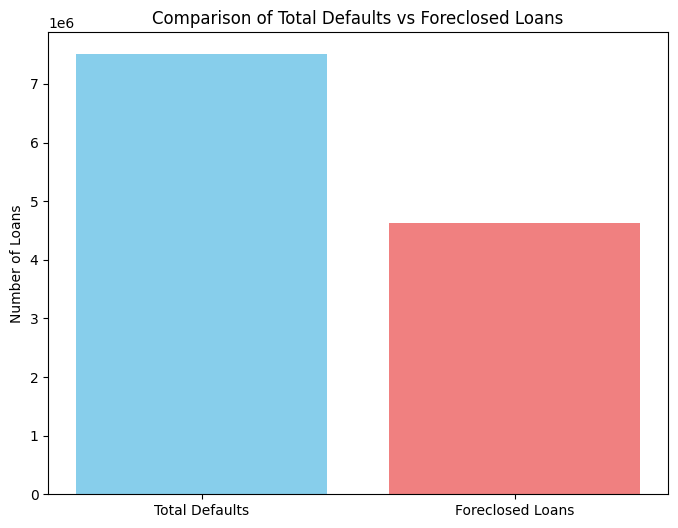

In [ ]:
#Filtering for all defaulted loans
defaulted_df = combined_df_quarters.filter(F.col("loan_status") == "Defaulted")

# Renaming col_53
defaulted_df = defaulted_df.withColumnRenamed("col_53", "foreclosure_data")

# Counting total defaulted loans
total_defaults = defaulted_df.count()

# Counting loans with foreclosure data
foreclosed_loans = defaulted_df.filter(F.col("foreclosure_data").isNotNull()).count()

# Calculating the recovery percentage
recovery_percentage = (foreclosed_loans / total_defaults) * 100
print(f"Recovery Percentage (Foreclosed Loans / Total Defaults): {recovery_percentage:.2f}%")

# Converting data for visualization
categories = ['Total Defaults', 'Foreclosed Loans']
values = [total_defaults, foreclosed_loans]

# Create a plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightcoral'])
plt.title('Comparison of Total Defaults vs Foreclosed Loans')
plt.ylabel('Number of Loans')

plt.show()

The bar chart compares the number of total defaults to foreclosed loans. It reveals that the number of total defaults is significantly higher than the number of foreclosed loans. Specifically, the chart shows approximately 7 million total defaults compared to 4.5 million foreclosed loans. This suggests that a portion of defaulted loans are not resulting in foreclosure, potentially due to other resolution methods or ongoing legal processes.

### 8) Plot average, median, and variance of property price changes over the entire duration, bucketed by month.


In [ ]:
#Filtering out rows where col_67 or col_65 is NULL
combined_df_filtered = combined_df.filter(
    (combined_df['col_67'].isNotNull()) & (combined_df['col_65'].isNotNull())
)

# Calculating the price change percentage
combined_df_filtered = combined_df_filtered.withColumn(
    'price_change_pct',
    ((combined_df_filtered['col_67'] - combined_df_filtered['col_65']) / combined_df_filtered['col_65']) * 100
)

# Verifying the price_change_pct calculation
combined_df_filtered.select('col_67', 'col_65', 'price_change_pct').show(10)

combined_df_filtered = combined_df_filtered.filter((combined_df_filtered['price_change_pct'].isNotNull()))

# Extracting the month from col_13
combined_df_filtered = combined_df_filtered.withColumn(
    "month", F.substring(F.col("col_13"), 1, 2).cast("int")
)

# Verifying the price_change_pct calculation
combined_df_filtered.select('month','col_67', 'col_65', 'price_change_pct').show(10)

+------+------+----------------+
|col_67|col_65|price_change_pct|
+------+------+----------------+
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
|      |      |            NULL|
+------+------+----------------+
only showing top 10 rows

+-----+------+------+----------------+
|month|col_67|col_65|price_change_pct|
+-----+------+------+----------------+
+-----+------+------+----------------+



Initially col_67, col_65 has empty values and price_change_pct has NULL values. After removing the NULL values and after adding the month column all the columns are changed to empty